# Bethe-Bloch

This notebook explores the energy loss of particles as modeled by the Bethe-Block equation.
As an exercie you will plot the average energy loss for different particles in different materials.  We will not model the statistical fluctuations of nuclear interactions of hadrons, but the results will give a reasonable picture of ionizing energy losses, which will dominate in many cases at lower energies.

In [2]:
import numpy as np

## Helper classes
Define materials and particles

For materials, use the periodic table to determine Z, and A (standard atomic weight).  <br>
The density and ionization energy used in this calculation should be taken from the tuned values in the GEANT4 simulation package materials [database](https://geant4-userdoc.web.cern.ch/UsersGuides/ForApplicationDeveloper/html/Appendix/materialNames.html).  <br>
note: for composite materials defined in GEANT, use the average Z,A values based on the molecular structure, <br>
eg water = 2xH,1xO, so $Z_{H2O}=(2Z_H+Z_O)/3$ , etc

In [3]:
class Material:
    def __init__(self,name,Z,A,density,IeV):
        self.name=name
        self.Z=Z              # atomic number
        self.A=A              # grm/mol
        self.density=density  # grms/cm^3
        self.IeV=IeV          # ionization energy (related)


mCopper=Material("Copper",29,63.55,8.96,322)
mAluminum=Material("Aluminum",13,26.98,2.70,166)
mTungsten=Material("Tungsten",74,183.84,19.3,727)

class Particle:
    def __init__(self,name,m,z):
        self.name=name
        self.m=m    # MeV/c^2
        self.z=z    # charge number
        
pMuon=Particle("muon",105.66,1)

The Bethe-Bloch equation is implement below

In [4]:
me = 0.511  # MeV/c^2
K = .3071   # Mev.cm^2/mol.
q = 1.6E-19 # Coulombs
hbar = 6.582E-22 # MeV.s
r_e = 2.817940E-15 # m
N_A = 6.022E23 # 
alpha = 1.0/137.036 

def BetheBloch(M,pt,E,dx,opt=""):  # inputs: Material, Particle, Energy in MeV, material thickness [cm]
    #estimation of ionization energy, replaced by GEANT database values
    #print ('Density =', M.density, ' A =',M.A, 'and Z =', M.Z)
    #if M.Z > 13:
    #    IeV = ((9.76*M.Z)+58.8*np.power(M.Z, -0.19))  #  Z > 13 
    #else:
    #    IeV = 12 * M.Z + 7
    #I = IeV/1E6  #  Express I in MeV (~ionization energy)
    I=M.IeV/1e6
    #print(f"I = {I:.3E} MeV")
    gamma = (E+pt.m)/pt.m
    beta = np.sqrt(1-(1/gamma)**2) 
    
    numDens=(N_A/M.A)*M.density*M.Z * 1E6  # electrons/m^3

    freq = np.sqrt((numDens * np.power(q,2))/(8.85E-12*9.11E-31)) 
    # Plasma frequency = √(n_e.q^2/\epsilon_o * m_e) s^-1
    #print (f"Plasma frequency = {freq:3E} rads/sec")

    delta = np.log((hbar * freq)/I) + np.log(beta * gamma) - 0.5           
    #print (f"Delta = {delta:3f}")

    num = 2 * me * np.power(gamma*beta,2)
    den = 1 + ((2 * gamma * me)/pt.m) + (me/pt.m)**2
    Wmax = num/den
    #print (f"Wmax = {Wmax:.3f} MeV")
    
    stopping_power = K* pt.z**2 * (M.Z/M.A) * (1/beta**2)
    stopping_power = stopping_power * (0.5*np.log(2 * me * (beta*gamma)**2 * Wmax/I**2) - beta**2 - delta) # MeV/cm
    #print (f'Stopping Power (-dE/dx) = {stopping_power:.3f} MeV.cm^2/g')

    lsp = stopping_power*M.density
    #print (f'Linear stopping power = {lsp:.3f} MeV/cm')
    Eloss = lsp*dx
    if opt=="verbose": print (f'Energy lost by a {E} MeV {pt.name} in 5mm of {M.name} is: {Eloss:.3f} MeV')
    return Eloss  # result in MeV

Example usage of Bethe-Bloch function to calculate the average energy loss of a particle in a certain thickness of material.

In [5]:
BetheBloch(mCopper,pMuon,1000,0.5)  # E=1000 MeV, dx=0.5 cm

7.335795197594423

In [6]:
BetheBloch(mAluminum,pMuon,1000,0.5,"verbose")  # E=1000 MeV, dx=0.5 cm

Energy lost by a 1000 MeV muon in 5mm of Aluminum is: 2.450 MeV


2.449545026820362

In [7]:
dE=BetheBloch(mTungsten,pMuon,1000,0.5)  # E=1000 MeV, dx=0.5 cm
print("Eloss",dE)

Eloss 13.551805819854984


# Project

To perform a rough simulation of a particle losing energy by interacting with matter, perform the following steps:
  * Define a particle and type of material to use as shown above
  * Choose a small step size through the material and "take a step"
    * Calculate the energy loss in such a step
    * Reduce the particle's energy by that amount
  * Repeat until the particles energy is below some critical value that is small compared to the initial energy, eg 10 keV.  Note that when the particle slows it will start to loos energy very quickly, so in your final step the Bethe-Bloch calculation will probably report more energy is lost than the particle had to start.  Just set the energy loss to the total energy in that case and consider the particle to be stopped.

You may have to tune your step sizes to get a good picture of the logitudinal energy deposition, aim for at least 50 steps.  Your distributions should reoughly resemble the Bragg peaks on page 7 of our calorimetry slides.

In [10]:
#define particles (name, mass, charge)
# the proton
pProton = Particle("proton",938.27,1)

# the pion
pPion = Particle("pion+",139.57,1) #positively charged pion

# the electron
pElectron = Particle("electron", 0.51, -1)

#define materials (name,Z,A,density,IeV)
# lead
mLead = Material("Lead",82,207.2,11.35,823)

# water
mWater = Material("Water",3.33,6.01,1,78)

# liquid helium (search for density, use IeV from GEANT database)
mHelium = Material("Liquid Helium",2,4,.125,41.8)

# freon-12
mFreon12 = Material("Freon-12",11.6,24.18,1.12,143)

## Make graphs of the energy distribution for protons 
E = (10MeV,50MeV,100MeV,500MeV,1GeV) in liquid helium, aluminum, copper, lead, tungsten

In [ ]:
# work goes here


## Make graphs of the energy distribution for pions 
E = (10MeV,50MeV,100MeV,500MeV,1GeV) in aluminum, copper, lead, tungsten

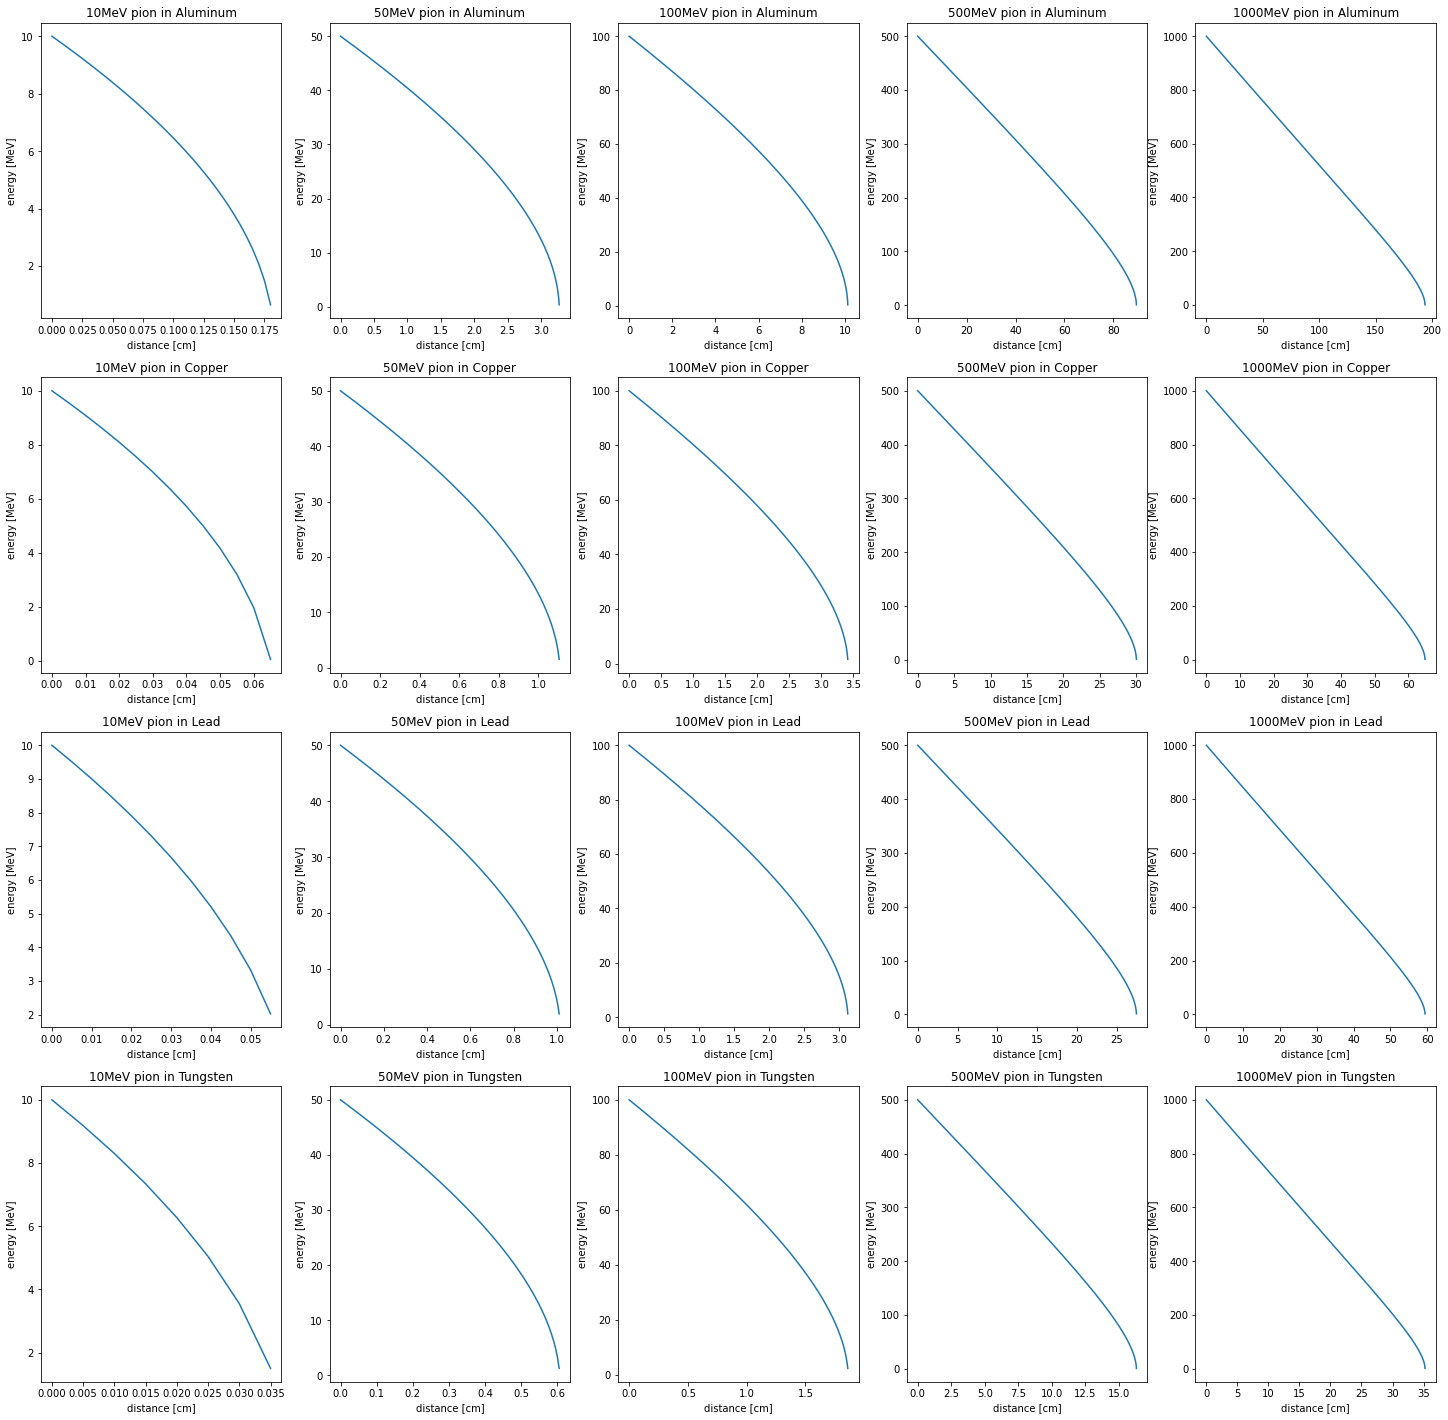

In [33]:
from matplotlib import pyplot as plt
plt.figure(figsize=(25,25))

# list of starting energies
lE = [10, 50, 100, 500, 1000]
#materials
lM = [mAluminum, mCopper, mLead, mTungsten]

index = range(50)

# starting parameters
x = 0
dx = 0.005 # in cm
i = 0
# perform Bethe-Bloch until Energy of particle reaches critical lower limit
for material in lM:
    for energy in lE:
        eName = str(energy)
        arr = [(0,energy)]
        x = 0
        while energy >= .01:
            dE = BetheBloch(material, pPion, energy, dx, "")
            x += dx
            energy -= dE
            if energy > 0:
                arr.append((x,energy))
        xPts,yPts = zip(*arr)
        plt.subplot(4,5,i+1)
        plt.plot(xPts,yPts)
        plt.title(eName + "MeV pion in " + material.name)
        plt.xlabel('distance [cm]')
        plt.ylabel('energy [MeV]')
        i += 1



## Make graphs of the energy distribution for muons 
E = (10MeV,50MeV,100MeV,500MeV,1GeV) in aluminum, copper, lead, tungsten

In [ ]:
# work goes here

## Make graphs of the energy distribution for electrons 
E = (1MeV,5MeV,10MeV) in liquid helium, freon-12, copper, lead, tungsten

In [ ]:
# work goes here

## Perform a short study similar to cancer treatment strategies
Assume an inoperable tumor is centered at a location 8cm inside a patient. You can assume the tumor 2cm thick.  Use a water target to mimic the human body (in reality more sophosticated tissue models are available, but water is a reasonable choice as a first pass).  Assume you have the ability to generate the particles above at different energies.  

An ideal treatment strategy is to use a particle type and energy that deposits most of its energy at the site of the tumor, but mimimal energy in the healthy tissue in front or behind the tumor.  eg we want the max energy deposition to be at the tumor and the logitudinal spread of that deposition peak should not be broad.  

What particle and energy would work best?  Discuss your conclusion.

In [ ]:
# work goes here